In [9]:
#cd '/Users/nikhilsingh/Downloads/Dalmia_machine_learning/Nikhil'

In [1]:
import numpy as np 
import psycopg2
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#Credentials for DB
host="database-dalmia.cms6cet2hwec.ap-south-1.rds.amazonaws.com"
database="dalmia_digital"
user="postgres"
password="dalmia123"
sql_query =  "SELECT sold_to_party_code,billing_date,bill_quantity FROM dalmia_sales.sales_data where billing_date > '2020-04-01' and sold_to_party_code between 7000000 and 7099999"


class DB_Data:
    
    def __init__(self, host, database, user, password, sql_query):
        self.host = host
        self.database = database
        self.user = user
        self.password = password
        self.sql_query = sql_query
        
#Database connection funtion        
    def db_data(self):
        conn = psycopg2.connect(
            host=self.host,
            database=self.database,
            user=self.user,
            password=self.password
        )
        sql_query = self.sql_query
        df = pd.read_sql_query(sql_query, conn)
        conn.close()
        return df

#Function to create date columns 
    def create_date_columns(self):
        df = self.db_data()
        new_df = pd.DataFrame()
        for df_item in [df]:
            df_item['date'] = pd.to_datetime(df_item['billing_date'])
            df_item['Month_Year'] = pd.to_datetime(df_item['date']).dt.strftime('%Y-%m')
            df_item['Year'] = pd.to_datetime(df_item['date']).dt.year
            df_item['Quarter'] = df_item['date'].dt.to_period('Q')
            new_df = pd.concat([new_df, df_item], axis=0)
        return new_df

#Pivot data creation for 
    def pivot_data(self):
        df = self.create_date_columns()
        df_sales = df[['sold_to_party_code', 'Month_Year', 'bill_quantity']]
        df_group_month = df_sales.groupby(['sold_to_party_code', 'Month_Year']).agg({'bill_quantity': 'sum'}).reset_index()
        df_group_month.columns = ['Sold To Party Code', 'Month Year', 'Sum']
        pivot_table = pd.pivot_table(df_group_month, values='Sum', columns='Month Year', index='Sold To Party Code')
        pivot_table = pivot_table.fillna(0)
        return pivot_table
    
#New Dealers    
    def count_zeros_before_first_nonzero(self , row):
        count = 0
        for value in row:
            if value == 0:
                count += 1
            else:
                break 
        return count

#Result_matrix creation
    def count_trailing_zeros_before_end_index(self, df, end_index):
        counts = []
        for row in df.itertuples(index=False):
            count = 0
            for i in range(end_index - 1, -1, -1):
                if row[i] == 0:
                    count += 1
                else:
                    break
            counts.append(count)
        return counts

    def create_result_matrix(self):
        df = self.pivot_data()
        df['month_new_dealer'] = df.apply(self.count_zeros_before_first_nonzero,axis =1)
        df = df[df['month_new_dealer']<=14]
        result_matrix = pd.DataFrame(index=df.index)
        for i in range(len(df.columns)):
            string = str(i)
            result_matrix[string] = self.count_trailing_zeros_before_end_index(df, i)
        result_matrix.drop('0', axis=1, inplace=True)
        return df , result_matrix
    
    def inactive(self , value):
        if value == 0: 
            return 'Active'
        elif value == 1: 
            return 'Active_1N'
        elif value == 2: 
            return 'Active_2N'
        elif value == 3: 
            return 'Active_3N'
        elif value>3 and value <=12:
            return 'Inactive'
        else: 
            return 'Churn'
        
#Activity Matrix      
    def state_matrix(self):
        df, result_matrix = self.create_result_matrix()
        for i in result_matrix.columns:
            result_matrix[i] = result_matrix[i].apply(self.inactive)
        result_matrix['month_new_dealer'] = df['month_new_dealer']
        for i in result_matrix.index:
            value = df.loc[i,'month_new_dealer'] 
            result_matrix.loc[i, :value] = '-'
        result_matrix.columns = df.columns
        df.drop('month_new_dealer', axis = 1 , inplace = True)
        result_matrix.drop('month_new_dealer', axis = 1 , inplace = True)
        return df, result_matrix


In [2]:
from sklearn.preprocessing import LabelEncoder
class Train:
    
    def __init__(self):
        # Create an instance of the DB_Data class with appropriate parameters
        self.db_data_instance = DB_Data(host, database, user, password, sql_query)

#training data 
    def train_data(self, pivot,result_matrix):
        cols = list(pivot.columns)
        col_inv = cols[::-1]
        df_inv = pivot[col_inv]
        
        # Call the count_zeros_before_first_nonzero function from the DB_Data instance
        df_inv['zero_count'] = df_inv.apply(self.db_data_instance.count_zeros_before_first_nonzero, axis=1)
        df_inv = df_inv[df_inv['zero_count'] <= 12]
        #target variable for the training data 
        result_matrix = result_matrix[result_matrix.index.isin(df_inv.index)]
    
        result_matrix_2 = result_matrix.drop([ '2023-04', '2023-05', '2023-06', '2023-07', '2023-08'],axis = 1)
        result_matrix_2 = result_matrix_2[list(result_matrix_2.columns)[::-1]]
        result_matrix['zero_count'] = df_inv['zero_count']
        print(result_matrix_2.shape)
        print(df_inv.shape)
        test = pd.DataFrame(columns=['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'], index=df_inv.index)
        
        result_1 = pd.DataFrame(columns=['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12'], index=df_inv.index)
        
        #rolling window data for training
        for i in range(len(df_inv.index)):
            value = df_inv.iloc[i, -1]
            test.iloc[i, :] = df_inv.iloc[i, value:value+24]
            result_1.iloc[i,:] = result_matrix_2.iloc[i, value:value+12]
            
       
        y = pd.DataFrame(columns = ['state_m','state_m+1','m+2'], index = result_matrix.index)
        for i in range(result_matrix.shape[0]):
            value = df_inv.iloc[i , -1]
            #print(i)
            y.iloc[i,] = result_matrix.iloc[i , 28-value-4:28-value-1]     
        return test,y, result_1


    def data(self , test, result_1):
        df = pd.DataFrame()
        df[['m-1','m-2','m-3']]=test[['m-1','m-2','m-3']]
        df['m-1_yoy'] = test['m-1']-test['m-13']
        df['m-2_yoy'] = test['m-2']-test['m-14']
        df['m-3_yoy'] = test['m-3']-test['m-15']
        df['m-1_hy'] = test['m-1']-test['m-7']
        df['m-2_hy'] = test['m-2']-test['m-8']
        df['m-3_hy'] = test['m-3']-test['m-9']
        df['m-1_qoq'] = test['m-1']-test['m-4']
        df['m-2_qoq'] = test['m-2']-test['m-5']
        df['m-3_qoq'] = test['m-3']-test['m-6']
        test['avg_sales'] = test.mean(axis = 1)
        df = df.merge(test['avg_sales'], left_index = True , right_index = True , how = 'inner')
        status_columns = result_1.columns[1:]  # Exclude the "Identifier" column
        for index, row in result_1.iterrows():
            row_counts = row[status_columns].value_counts()
            for status_col, count in row_counts.items():
                result_1.at[index, f"{status_col}_count"] = count
        result_1 = result_1[['Active_1N_count','Active_2N_count','Active_3N_count','Inactive_count']]
        result_1 = result_1.fillna(0)
        df = df.merge(result_1, left_index = True , right_index=True , how = 'inner')
        
        return df
    
    def discount_pd(self, df , discount_df , pd_df):
        df = df.merge(discount_df['avg_discount'], left_index= True , right_index = True,
                     how = 'left').merge(pd_df['avg_pd'], left_index = True , right_index = True, how = 'left')
        return df
    
    def district(self , df , distt_df, region_df):
        df = df.merge(distt_df['sold_to_party_district_name'], left_index = True , 
                      right_index = True , how = 'inner').merge(region_df['sales_region'] , left_index = True , 
                                                                right_index = True , how = 'left')
        le = LabelEncoder()
        df['sold_to_party_district_name'] = le.fit_transform( df['sold_to_party_district_name'])
        df['sales_region'] = le.fit_transform( df['sales_region'])
        return df

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import joblib

class Training_module:
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    def train_decision_tree(self):
        model = DecisionTreeClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "Decision Tree")
        self.save_model(model, "Decision_Tree") 

    def train_svm(self):
        model = SVC(probability=True,kernel='rbf',class_weight={1:2.0})
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "SVM")
        self.save_model(model, "SVM")

    def train_random_forest(self):
        model = RandomForestClassifier(n_estimators=61)
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "Random Forest")
        self.save_model(model, "Random Forest")

    def train_knn(self):
        model = KNeighborsClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "K-Nearest Neighbors")
        self.save_model(model, "K-Nearest Neighbors")

    def train_xgboost(self):
        model = XGBClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "XGBoost")
        self.save_model(model, "XGBoost")

    def train_xgboost_rf(self):
        model = XGBRFClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "XGBoost Random Forest")
        self.save_model(model, "XGBoost Random Forest")

    def evaluate_model(self, model, model_name):
        y_pred = model.predict(self.X_test)
        y_prob = model.predict_proba(self.X_test)[:, 1]

        print(f"Classification Report for {model_name}:\n")
        print(classification_report(self.y_test, y_pred))

        print(f"Confusion Matrix for {model_name}:\n")
        print(confusion_matrix(self.y_test, y_pred))

        self.plot_roc_curve(model, model_name, y_prob)

    def plot_roc_curve(self, model, model_name, y_prob):
        n_classes = len(set(self.y))

        if n_classes == 2:
            self.plot_binary_roc_curve(model_name, self.y_test, y_prob)
        else:
            self.plot_multiclass_roc_curve(model_name, self.y_test, y_prob, n_classes)

    def plot_binary_roc_curve(self, model_name, y_test, y_prob):
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()

    def plot_multiclass_roc_curve(self, model_name, y_test, y_prob, n_classes):
        y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(8, 6))
        colors = ['darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Multiclass ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()
        
        
    def save_model(self, model, model_name):
        filename = f"{model_name}_model.pkl"
        joblib.dump(model, filename)

    def load_model(self, model_name):
        filename = f"{model_name}_model.pkl"
        return joblib.load(filename)
        
    def validate_saved_model(self, model_name, X_val , y_val):
        loaded_model = self.load_model(model_name)
        # You can use the loaded model for validation or inference
        y_pred = loaded_model.predict(X_val)
        y_prob = loaded_model.predict_proba(X_val)[:, 1]
        print(f"Validation Results for {model_name}:\n")
        print(classification_report(y_val, y_pred))
        print(confusion_matrix(y_val, y_pred))
        self.plot_binary_roc_curve(loaded_model, y_val, y_prob)
        return y_pred  ,y_prob


In [4]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier  # Import Random Forest

class ModelTuner:
    def __init__(self, model, param_grid, cv=5):
        self.model = model
        self.param_grid = param_grid
        self.cv = cv
        self.best_model = None

    def tune_parameters(self, X, y):
        kfold = KFold(n_splits=self.cv, shuffle=True, random_state=42)
        scorer = make_scorer(recall_score)
        
        grid_search = GridSearchCV(self.model, self.param_grid, scoring=scorer, cv=kfold, n_jobs=-1)
        grid_search.fit(X, y)
        
        self.best_model = grid_search.best_estimator_
        print("Best Parameters:", grid_search.best_params_)
        print("Best Accuracy:", grid_search.best_score_)

    def evaluate_best_model(self, X, y):
        if self.best_model is not None:
            y_pred = self.best_model.predict(X)
            accuracy = accuracy_score(y, y_pred)
            print("Accuracy of the Best Model:", accuracy)
        else:
            print("No best model found. Please run 'tune_parameters' first.")

# Example usage with Random Forest:
if __name__ == "__main__":
   

    param_grid = {
      
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    #'criterion': ['gini', 'entropy'],  # Criterion for splitting
    #'max_depth': [None, 10, 20, 30, 40],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be a leaf node
    #'max_features': ['auto', 'sqrt', 'log2', None],  # Number of features to consider when looking for the best split
    #'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    #'class_weight': [None, 'balanced'],  # Weights associated with classes

    }

    rf_model = RandomForestClassifier()  # Use Random Forest classifier
    tuner = ModelTuner(rf_model, param_grid)
    tuner.tune_parameters(X, y_1)
    tuner.evaluate_best_model(X, y_1)

NameError: name 'X' is not defined

In [5]:
instance = DB_Data(host, database, user, password, sql_query)
#pivot, result_matrix = instance.state_matrix()

In [12]:
pivot, result_matrix = instance.state_matrix()

In [13]:
pivot_prev = pd.read_csv('previous_year_data.csv')

In [14]:
pivot_prev.index = pivot_prev['Sold To Party Code']
pivot_prev.drop('Sold To Party Code', axis = 1 , inplace = True)
pivot_1 = pivot_prev.merge(pivot , left_index = True , right_index=True , how = 'right')
pivot_1 = pivot_1.fillna(0)
discount_df = pd.read_csv('data/discount_pivot.csv')
pd_df = pd.read_csv('data/pd_pivot.csv')
discount_df.index = discount_df['Sold To Party Code']
pd_df.index = pd_df['Sold To Party Code']
discount_df.drop('Sold To Party Code', axis = 1 , inplace =True)
pd_df.drop('Sold To Party Code', axis = 1 , inplace =True)
discount_df['avg_discount'] = discount_df.mean(axis = 1)
pd_df['avg_pd'] = pd_df.mean(axis = 1)
pivot_2 = pivot_1.drop([ '2023-04', '2023-05', '2023-06', '2023-07', '2023-08'],axis = 1)
result_matrix_2 = result_matrix.drop([ '2023-06', '2023-07', '2023-08'],axis = 1)

In [15]:
instance_2 = Train()
test , y , result_1= instance_2.train_data(pivot_2,result_matrix)

(10216, 24)
(10216, 37)


In [16]:
train_df = instance_2.data(test , result_1)
train_df = instance_2.discount_pd(train_df , discount_df , pd_df)
distt_df = pd.read_csv('data/unique_districts.csv')
region_df = pd.read_csv('data/unique_region.csv')
distt_df.index = distt_df['sold_to_party_code']
region_df.index = region_df['sold_to_party_code']
train_df = instance_2.district(train_df , distt_df, region_df)

In [21]:
train_df = train_df.fillna(0)

### Testing models

In [22]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(train_df)
y = y[y.index.isin(train_df.index)]
y_1 = y['state_m'].replace({'Active':0, 'Active_1N':1})
trainer = Training_module(X, y_1)

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2354
           1       0.73      0.69      0.71      1018

    accuracy                           0.83      3372
   macro avg       0.80      0.79      0.80      3372
weighted avg       0.83      0.83      0.83      3372

Confusion Matrix for Random Forest:

[[2096  258]
 [ 312  706]]


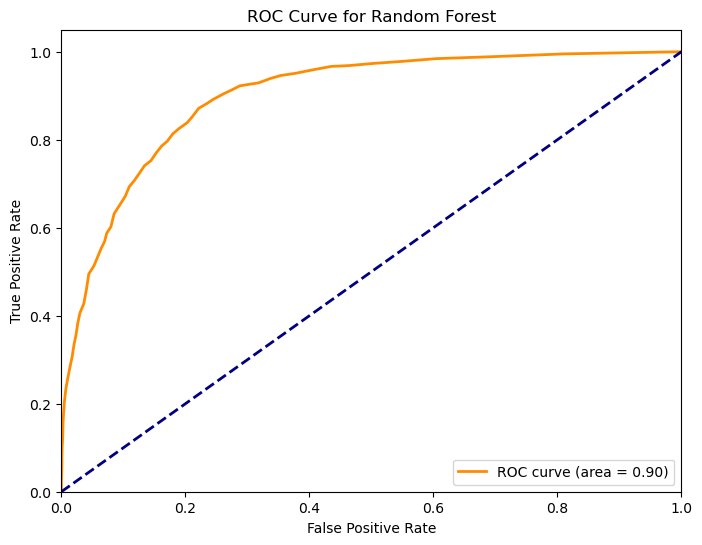

In [23]:
trainer.train_random_forest()

In [68]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier  # Import Random Forest

class ModelTuner:
    def __init__(self, model, param_grid, cv=5):
        self.model = model
        self.param_grid = param_grid
        self.cv = cv
        self.best_model = None

    def tune_parameters(self, X, y):
        kfold = KFold(n_splits=self.cv, shuffle=True, random_state=42)
        scorer = make_scorer(recall_score )
        
        grid_search = GridSearchCV(self.model, self.param_grid, scoring=scorer, cv=kfold, n_jobs=-1)
        grid_search.fit(X, y)
        
        self.best_model = grid_search.best_estimator_
        print("Best Parameters:", grid_search.best_params_)
        print("Best Recall:", grid_search.best_score_)

    def evaluate_best_model(self, X, y):
        if self.best_model is not None:
            y_pred = self.best_model.predict(X)
            recall = recall_score(y, y_pred)
            print("Recall of the Best Model:", recall)
        else:
            print("No best model found. Please run 'tune_parameters' first.")

# Example usage with Random Forest:
if __name__ == "__main__":
   

    param_grid = {
      
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    #'criterion': ['gini', 'entropy'],  # Criterion for splitting
    #'max_depth': [None, 10, 20, 30, 40],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be a leaf node
    #'max_features': ['auto', 'sqrt', 'log2', None],  # Number of features to consider when looking for the best split
    #'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    #'class_weight': [None, 'balanced'],  # Weights associated with classes

    }
    X_scaled = sc.fit_transform(X)

    rf_model = RandomForestClassifier()  # Use Random Forest classifier
    tuner = ModelTuner(rf_model, param_grid)
    tuner.tune_parameters(X_scaled, y_1)
    tuner.evaluate_best_model(X_scaled, y_1)

Best Parameters: {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best Recall: 0.7199905345679791
Recall of the Best Model: 0.9266211604095563


In [24]:
discount_24 = pd.read_excel('data/FY24-Discount.xlsx')
discount_groupby = discount_24.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby = discount_groupby.fillna(0)
discount_groupby.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby.index = discount_groupby['sold_to_party_code']
result_sep = result_matrix[result_matrix['2023-08']=='Active']
#result_jun = result_matrix[result_matrix['2023-06']=='Active_1N']
pivot_sep = pivot[pivot.index.isin(result_sep.index)]
#pivot_ = pivot[pivot.index.isin(result_sep.index)]
pivot_sep = pivot_sep[['2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07','2023-08']]
# pivot_jun = pivot_jun[['2021-06','2021-07','2021-08', '2021-09',
#        '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
#        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
result_sep_1 = result_sep[['2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07','2023-08']]
# result_jun_1 = result_jun[['2022-06','2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
pivot_sep.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
# pivot_jun.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
#                                     'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
result_sep_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
# result_jun_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
val_df = instance_2.data(pivot_sep, result_sep_1)
val_df = instance_2.discount_pd(val_df , discount_groupby[['avg_discount']], discount_groupby[['avg_pd']])
val_df = instance_2.district(val_df , distt_df , region_df)

In [25]:
val_df = val_df.dropna()

In [26]:
#discount_24 = pd.read_excel('data/FY24-Discount.xlsx')
discount_24_1 = discount_24[discount_24['Month']!= "08'23"]
discount_groupby_aug = discount_24_1.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby_aug = discount_groupby_aug.fillna(0)
discount_groupby_aug.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby_aug.index = discount_groupby_aug['sold_to_party_code']

In [27]:
discount_24_2 = discount_24_1[discount_24_1['Month']!= "07'23"]
discount_groupby_jul = discount_24_2.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby_jul = discount_groupby_jul.fillna(0)
discount_groupby_jul.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby_jul.index = discount_groupby_jul['sold_to_party_code']

In [28]:


result_aug = result_matrix[result_matrix['2023-08']=='Active_1N']
#result_jun = result_matrix[result_matrix['2023-06']=='Active_1N']
pivot_aug = pivot[pivot.index.isin(result_aug.index)]
#pivot_ = pivot[pivot.index.isin(result_sep.index)]
pivot_aug = pivot_aug[['2021-08','2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
# pivot_jun = pivot_jun[['2021-06','2021-07','2021-08', '2021-09',
#        '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
#        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
result_aug_1 = result_aug[['2022-08','2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
# result_jun_1 = result_jun[['2022-06','2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
pivot_aug.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
# pivot_jun.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
#                                     'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
result_aug_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
# result_jun_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
val_df_aug= instance_2.data(pivot_aug, result_aug_1)
val_df_aug = instance_2.discount_pd(val_df_aug , discount_groupby_aug[['avg_discount']], discount_groupby_aug[['avg_pd']])
val_df_aug = instance_2.district(val_df_aug , distt_df , region_df)

In [29]:
result_jul = result_matrix[result_matrix['2023-08']=='Active_2N']
#result_jun = result_matrix[result_matrix['2023-06']=='Active_1N']
pivot_jul = pivot[pivot.index.isin(result_jul.index)]
#pivot_ = pivot[pivot.index.isin(result_sep.index)]
pivot_jul = pivot_jul[['2023-07','2021-08','2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06']]
# pivot_jun = pivot_jun[['2021-06','2021-07','2021-08', '2021-09',
#        '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
#        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
result_jul_1 = result_jul[['2023-07','2022-08','2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06']]
# result_jun_1 = result_jun[['2022-06','2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
pivot_jul.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
# pivot_jun.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
#                                     'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
result_jul_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
# result_jun_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
val_df_jul= instance_2.data(pivot_jul, result_jul_1)
val_df_jul = instance_2.discount_pd(val_df_jul , discount_groupby_jul[['avg_discount']], discount_groupby_jul[['avg_pd']])
val_df_jul = instance_2.district(val_df_jul , distt_df , region_df)

In [30]:
val_df_aug = val_df_aug.dropna()
val_df_jul = val_df_jul.dropna()

In [31]:
val_df_jul_aug = pd.concat([val_df_aug,val_df_jul],axis = 0)

In [32]:
import joblib

# Load the model
loaded_model = joblib.load('Random Forest_model.pkl')
val_df_1 = sc.fit_transform(val_df)

# Make predictions using the loaded model
predictions = loaded_model.predict(val_df_1)
val_df['predicted'] = predictions

In [36]:
val_df

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,Active_1N_count,Active_2N_count,Active_3N_count,Inactive_count,avg_discount,avg_pd,sold_to_party_district_name,sales_region,predicted,predict_proba
7000004,80.00,80.0,96.0,60.0,58.0,61.00,-10.00,5.0,-26.50,-31.00,...,0.0,0.0,0.0,0.0,26859.696000,9972.625000,25,1,0,0.016393
7000010,13.00,24.0,12.0,1.0,-9.8,12.00,13.00,24.0,12.00,-11.00,...,0.0,1.0,1.0,5.0,2653.938437,937.490000,51,1,1,0.540984
7000022,24.00,12.0,12.0,12.0,0.0,9.00,24.00,-12.0,-9.00,-3.00,...,2.0,0.0,0.0,0.0,3309.500625,2083.333333,149,1,1,0.704918
7000025,121.00,147.0,109.0,46.0,-28.0,-52.00,-16.00,-20.0,36.00,-11.00,...,0.0,0.0,0.0,0.0,51799.686500,19921.866667,237,1,0,0.000000
7000029,90.00,90.0,55.0,30.0,60.0,-79.90,2.00,30.0,-58.00,30.00,...,0.0,0.0,0.0,0.0,26146.318000,12499.993333,141,1,0,0.180328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036699,13.00,0.0,12.0,0.0,-13.0,-1.00,13.00,-12.0,12.00,13.00,...,4.0,1.0,0.0,0.0,12817.500000,9937.500000,40,4,1,0.540984
7036703,11.75,0.0,0.0,-44.5,-54.0,-30.00,-8.25,0.0,0.00,1.75,...,4.0,3.0,0.0,0.0,1530.650000,3125.000000,323,1,1,0.590164
7036710,219.00,31.0,25.0,219.0,31.0,-5.00,161.00,-30.5,-33.00,191.00,...,1.0,0.0,0.0,0.0,12572.241000,4484.360000,131,1,0,0.377049
7036726,248.00,204.0,301.0,210.5,166.5,271.10,7.50,-3.5,129.50,-96.00,...,0.0,0.0,0.0,0.0,99918.768000,30210.925000,24,1,0,0.098361


In [33]:
pred_prob = loaded_model.predict_proba(val_df_1)
val_df['predict_proba'] = pred_prob[:,1]

In [34]:
val_df_jul_aug_1 = sc.fit_transform(val_df_jul_aug)

# Make predictions using the loaded model
predictions_1 = loaded_model.predict(val_df_jul_aug_1)

pred_prob_1 = loaded_model.predict_proba(val_df_jul_aug_1)
val_df_jul_aug['predicted'] = predictions_1
val_df_jul_aug['predict_proba'] = pred_prob_1[:,1]

In [35]:
val_df_jul_aug

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,Active_1N_count,Active_2N_count,Active_3N_count,Inactive_count,avg_discount,avg_pd,sold_to_party_district_name,sales_region,predicted,predict_proba
7000053,49.0,114.0,80.0,-107.0,-114.0,-121.0,-156.0,-78.0,-50.00,-44.00,...,0.0,0.0,0.0,0.0,37903.303672,7656.245000,27,1,0,0.213115
7000086,60.0,6.0,27.5,60.0,-6.0,22.5,49.0,-64.0,-74.50,4.00,...,0.0,0.0,1.0,1.0,13293.799766,8763.000000,75,1,0,0.180328
7000435,5.0,168.0,175.0,-80.0,37.0,79.0,-43.0,15.0,65.00,-12.00,...,0.0,0.0,0.0,0.0,38507.224375,5847.645000,27,1,1,0.557377
7000436,5.0,10.0,10.0,-15.0,0.0,-10.0,-16.0,-15.0,-25.00,-5.00,...,0.0,0.0,0.0,0.0,2339.507500,807.286667,2,1,1,0.540984
7000463,31.0,25.0,25.0,31.0,25.0,25.0,1.0,0.0,5.00,-0.25,...,1.0,0.0,0.0,0.0,7817.281875,4713.533333,11,1,0,0.032787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036525,10.0,10.0,15.0,-5.0,10.0,15.0,10.0,0.0,12.00,-20.00,...,1.0,1.0,1.0,0.0,8443.663333,5729.186667,70,4,0,0.475410
7036540,57.0,180.1,0.0,-491.5,180.1,0.0,57.0,81.1,-346.25,57.00,...,2.0,1.0,0.0,0.0,41153.687500,27109.375000,61,5,0,0.393443
7036645,3.5,6.0,2.0,0.5,6.0,2.0,-3.5,0.0,-15.45,-2.50,...,0.0,0.0,0.0,0.0,3913.353333,5498.166667,114,4,1,0.540984
7036676,25.0,25.0,0.0,15.0,25.0,0.0,-5.0,25.0,0.00,0.00,...,3.0,2.0,1.0,1.0,27648.435000,14648.435000,112,4,0,0.180328


In [823]:
pd.DataFrame(predictions_1).value_counts()

0    345
1    257
dtype: int64

In [824]:
val_df_jul_aug['actual'] = 1

### September data

In [37]:
sep_data = pd.read_csv('Trade_Sales_Sep23.csv')

In [38]:
sep_data = sep_data[sep_data['SOLD_PARTY_CODE'].isin(range(7000000,7100000))]
sep_groupby = sep_data.groupby('SOLD_PARTY_CODE').agg({'BILL_QTY':['sum']})
sep_groupby.columns = ['2023-09']

In [39]:
pivot_2 = pivot_1.merge(sep_groupby, left_index=True , right_index = True , how = 'outer')

In [40]:
pivot_2 = pivot_2.fillna(0)

In [41]:
pivot_2.loc[pivot_2['2023-09'] > 0, 'actual'] = 0
pivot_2.loc[pivot_2['2023-09'] <= 0, 'actual'] = 1

In [42]:
val_df = val_df.merge(pivot_2['actual'], left_index = True , right_index = True , how = 'left')

In [44]:
val_df

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,Active_2N_count,Active_3N_count,Inactive_count,avg_discount,avg_pd,sold_to_party_district_name,sales_region,predicted,predict_proba,actual
7000004,80.00,80.0,96.0,60.0,58.0,61.00,-10.00,5.0,-26.50,-31.00,...,0.0,0.0,0.0,26859.696000,9972.625000,25,1,0,0.016393,0.0
7000010,13.00,24.0,12.0,1.0,-9.8,12.00,13.00,24.0,12.00,-11.00,...,1.0,1.0,5.0,2653.938437,937.490000,51,1,1,0.540984,0.0
7000022,24.00,12.0,12.0,12.0,0.0,9.00,24.00,-12.0,-9.00,-3.00,...,0.0,0.0,0.0,3309.500625,2083.333333,149,1,1,0.704918,1.0
7000025,121.00,147.0,109.0,46.0,-28.0,-52.00,-16.00,-20.0,36.00,-11.00,...,0.0,0.0,0.0,51799.686500,19921.866667,237,1,0,0.000000,0.0
7000029,90.00,90.0,55.0,30.0,60.0,-79.90,2.00,30.0,-58.00,30.00,...,0.0,0.0,0.0,26146.318000,12499.993333,141,1,0,0.180328,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036699,13.00,0.0,12.0,0.0,-13.0,-1.00,13.00,-12.0,12.00,13.00,...,1.0,0.0,0.0,12817.500000,9937.500000,40,4,1,0.540984,1.0
7036703,11.75,0.0,0.0,-44.5,-54.0,-30.00,-8.25,0.0,0.00,1.75,...,3.0,0.0,0.0,1530.650000,3125.000000,323,1,1,0.590164,1.0
7036710,219.00,31.0,25.0,219.0,31.0,-5.00,161.00,-30.5,-33.00,191.00,...,0.0,0.0,0.0,12572.241000,4484.360000,131,1,0,0.377049,0.0
7036726,248.00,204.0,301.0,210.5,166.5,271.10,7.50,-3.5,129.50,-96.00,...,0.0,0.0,0.0,99918.768000,30210.925000,24,1,0,0.098361,0.0


In [45]:
val_df_jul_aug

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,Active_1N_count,Active_2N_count,Active_3N_count,Inactive_count,avg_discount,avg_pd,sold_to_party_district_name,sales_region,predicted,predict_proba
7000053,49.0,114.0,80.0,-107.0,-114.0,-121.0,-156.0,-78.0,-50.00,-44.00,...,0.0,0.0,0.0,0.0,37903.303672,7656.245000,27,1,0,0.213115
7000086,60.0,6.0,27.5,60.0,-6.0,22.5,49.0,-64.0,-74.50,4.00,...,0.0,0.0,1.0,1.0,13293.799766,8763.000000,75,1,0,0.180328
7000435,5.0,168.0,175.0,-80.0,37.0,79.0,-43.0,15.0,65.00,-12.00,...,0.0,0.0,0.0,0.0,38507.224375,5847.645000,27,1,1,0.557377
7000436,5.0,10.0,10.0,-15.0,0.0,-10.0,-16.0,-15.0,-25.00,-5.00,...,0.0,0.0,0.0,0.0,2339.507500,807.286667,2,1,1,0.540984
7000463,31.0,25.0,25.0,31.0,25.0,25.0,1.0,0.0,5.00,-0.25,...,1.0,0.0,0.0,0.0,7817.281875,4713.533333,11,1,0,0.032787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036525,10.0,10.0,15.0,-5.0,10.0,15.0,10.0,0.0,12.00,-20.00,...,1.0,1.0,1.0,0.0,8443.663333,5729.186667,70,4,0,0.475410
7036540,57.0,180.1,0.0,-491.5,180.1,0.0,57.0,81.1,-346.25,57.00,...,2.0,1.0,0.0,0.0,41153.687500,27109.375000,61,5,0,0.393443
7036645,3.5,6.0,2.0,0.5,6.0,2.0,-3.5,0.0,-15.45,-2.50,...,0.0,0.0,0.0,0.0,3913.353333,5498.166667,114,4,1,0.540984
7036676,25.0,25.0,0.0,15.0,25.0,0.0,-5.0,25.0,0.00,0.00,...,3.0,2.0,1.0,1.0,27648.435000,14648.435000,112,4,0,0.180328


In [46]:
val_1 = pd.concat([val_df, val_df_jul_aug], axis = 0)

In [47]:
print(confusion_matrix(val_df['actual'],val_df['predicted']))
print(classification_report(val_df['actual'],val_df['predicted']))

[[4428 1975]
 [ 121  488]]
              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81      6403
         1.0       0.20      0.80      0.32       609

    accuracy                           0.70      7012
   macro avg       0.59      0.75      0.56      7012
weighted avg       0.91      0.70      0.77      7012



In [615]:
# Make predictions using the loaded model
predict_proba = loaded_model.predict_proba(val_df_1)[:,1]
val_df['pred_proba'] = predict_proba 

In [616]:
predict_proba

array([0.05882353, 0.60784314, 0.58823529, ..., 0.29411765, 0.09803922,
       0.66666667])

In [421]:
# condition = (val_df['pred_proba'] <0.6) 
# val_df.loc[condition, 'predicted'] = 0

In [48]:
print(confusion_matrix(val_df['actual'],val_df['predicted']))
print(classification_report(val_df['actual'],val_df['predicted']))

[[4428 1975]
 [ 121  488]]
              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81      6403
         1.0       0.20      0.80      0.32       609

    accuracy                           0.70      7012
   macro avg       0.59      0.75      0.56      7012
weighted avg       0.91      0.70      0.77      7012



In [618]:
pivot_2['actual'] = pivot_2['actual'].replace({0:'Active',1:'Active_1N'})


In [619]:
result_matrix = result_matrix.merge(pivot_2['actual'], left_index = True , right_index = True , how = 'inner')

In [837]:
df = val_1[['actual','predicted','predict_proba']]
df = df.sort_values(by='predict_proba', ascending=False)



In [838]:
def percentile_rank_fun(data, value):
    sorted_data = sorted(data)
    count_below = sum(1 for x in sorted_data if x < value)
    percentile_rank = (count_below / len(sorted_data)) * 100
    return percentile_rank



In [839]:
percentile_rank = []
for i in df['predict_proba']:
    rank = percentile_rank_fun(df['predict_proba'], i)
   

In [534]:
engagement_list = pd.read_excel('engagement.xlsx')


In [840]:
#val_df['pred_proba'] = engagement_list['pred_proba'].values
#val_df['predicted'] = engagement_list['predicted_rf'].values
#val_df['predicted'] = val_df['predicted'].replace({'Active':0,'Active_1N':1})

def percentile_rank_fun(data, value):
    sorted_data = sorted(data)
    count_below = sum(1 for x in sorted_data if x < value)
    percentile_rank = (count_below / len(sorted_data)) * 100
    return percentile_rank
percentile_rank = []
for i in df['predict_proba']:
    rank = percentile_rank_fun(df['predict_proba'], i)
    percentile_rank.append(rank)

In [841]:
df['percentile_rank'] = percentile_rank

In [915]:
val_df['actual'].value_counts()

0.0    6403
1.0     609
Name: actual, dtype: int64

In [916]:
609/7012

0.08685111237877924

In [843]:
df['decile'] = pd.qcut(df['percentile_rank'], q=10, labels=False, duplicates='drop')

In [844]:
df

,actual,predicted,predict_proba,percentile_rank,decile
7032556,0.0,1,0.901961,99.986866,9
7034710,1.0,1,0.882353,99.921198,9
7005490,1.0,1,0.882353,99.921198,9
7014836,1.0,1,0.882353,99.921198,9
7030229,0.0,1,0.882353,99.921198,9
...,...,...,...,...,...
7036597,0.0,0,0.000000,0.000000,0
7018573,0.0,0,0.000000,0.000000,0
7008048,0.0,0,0.000000,0.000000,0
7021285,0.0,0,0.000000,0.000000,0


In [912]:
# Calculate cumulative gains and cumulative lift for each decile
cumulative_gains = []
cumulative_lift = []

total_positives = df['actual'].sum()
pos_act = []
pos_pred = []
for i in range(9,-1,-1):
    decile_data = df[df['decile']==i]
    cumulative_positives = decile_data['actual'].sum()
    predicted_positives = decile_data['predicted'].sum()
    print(cumulative_positives)
    pos_act.append(cumulative_positives)
    pos_pred.append( predicted_positives)
    cumulative_gains.append(cumulative_positives / total_positives)
    cumulative_lift.append(cumulative_gains[-1] / (decile_data.shape[0] / total_positives))

288.0
202.0
145.0
184.0
104.0
80.0
82.0
46.0
28.0
52.0


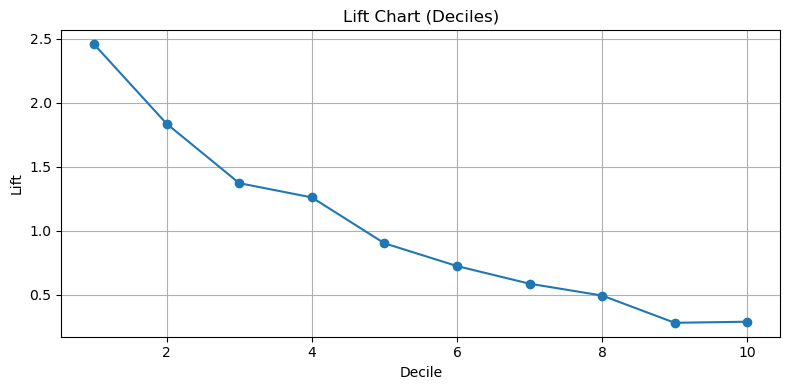

<Figure size 640x480 with 0 Axes>

In [913]:
for i in range(len(cumulative_lift)):
    cumulative_lift[i] = cumulative_lift[i]/0.16
    
plt.figure(figsize=(8, 4))
plt.plot(range(1,  11), cumulative_lift, marker='o')
plt.xlabel('Decile')
plt.ylabel('Lift')
plt.title('Lift Chart (Deciles)')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('lift.png')


In [639]:
df['decile'].value_counts()

0    1074
7     809
2     800
5     788
3     667
4     648
8     642
6     640
9     603
1     341
Name: decile, dtype: int64

In [910]:
df['decile'] = abs(df['decile']-9)

In [849]:
print(confusion_matrix(df['actual'],df['predicted']))
print(classification_report(df['actual'],df['predicted']))

[[4630 1773]
 [ 494  717]]
              precision    recall  f1-score   support

         0.0       0.90      0.72      0.80      6403
         1.0       0.29      0.59      0.39      1211

    accuracy                           0.70      7614
   macro avg       0.60      0.66      0.60      7614
weighted avg       0.81      0.70      0.74      7614



In [904]:
1211/7614

0.15904912004202784

In [905]:
288/733

0.39290586630286495

In [848]:
for i in range(0,10):
    decile_data = df[df['decile']==i]
    print(confusion_matrix(decile_data['actual'],decile_data['predicted']))
    print(classification_report(decile_data['actual'],decile_data['predicted']))

[[  0 445]
 [  0 288]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       445
         1.0       0.39      1.00      0.56       288

    accuracy                           0.39       733
   macro avg       0.20      0.50      0.28       733
weighted avg       0.15      0.39      0.22       733

[[  0 486]
 [  0 202]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       486
         1.0       0.29      1.00      0.45       202

    accuracy                           0.29       688
   macro avg       0.15      0.50      0.23       688
weighted avg       0.09      0.29      0.13       688

[[  0 516]
 [  0 145]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       516
         1.0       0.22      1.00      0.36       145

    accuracy                           0.22       661
   macro avg       0.11      0.50      0.18       661
weigh

In [903]:
(145+202+286)/1211

0.5227085053674649

,actual,predicted,pred_proba,percentile_rank,decile
7032556,0.0,1,0.901961,99.985739,0
7034710,1.0,1,0.882353,99.942955,0
7035468,0.0,1,0.882353,99.942955,0
7030229,0.0,1,0.882353,99.942955,0
7015192,0.0,1,0.862745,99.871649,0
...,...,...,...,...,...
7020843,0.0,0,0.000000,0.000000,9
7011848,0.0,0,0.000000,0.000000,9
7020852,0.0,0,0.000000,0.000000,9
7034943,0.0,0,0.000000,0.000000,9


In [427]:

# Calculate cumulative gains and cumulative lift for each decile
cumulative_gains = []
cumulative_lift = []

total_positives = df['actual'].sum()
pos_act = []
pos_pred = []
for i in range(1, len(deciles)):
    decile_data = df.iloc[deciles[i-1]:deciles[i]]
    cumulative_positives = decile_data['actual'].sum()
    predicted_positives = decile_data['predicted'].sum()
    pos_act.append(cumulative_positives)
    pos_pred.append( predicted_positives)
    cumulative_gains.append(cumulative_positives / total_positives)
    cumulative_lift.append(cumulative_gains[-1] / ((deciles[i] - deciles[i-1]) / total_positives))




In [428]:
for i in range(len(cumulative_lift)):
    cumulative_lift[i] = cumulative_lift[i]/0.086

In [430]:
pos_act

[153.0, 150.0, 125.0, 97.0, 46.0, 19.0, 11.0, 5.0, 3.0, 0.0]

In [341]:
cumulative_lift_1 = []
for i in range(len(cumulative_lift)):
    cumulative_lift_1.append(cumulative_lift[i]/(pos_act[i]/701))

0.24108416547788872
0.20684736091298145
0.19828815977175462
0.11269614835948645
0.05135520684736091
0.024251069900142655
0.024251069900142655
0.005706134094151213
0.0042796005706134095
0.0


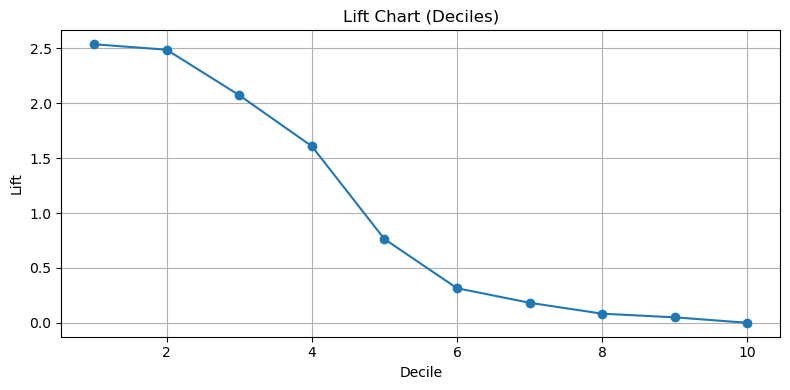

<Figure size 640x480 with 0 Axes>

In [429]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_deciles + 1), cumulative_lift, marker='o')
plt.xlabel('Decile')
plt.ylabel('Lift')
plt.title('Lift Chart (Deciles)')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('lift.png')
    

In [402]:
df.to_csv('precentile.csv')

,actual,predicted,pred_proba
7031672,0.0,1,0.843137
7030229,0.0,1,0.843137
7025358,1.0,1,0.843137
7032556,0.0,1,0.843137
7001065,1.0,1,0.843137
...,...,...,...
7025977,0.0,0,0.000000
7025973,0.0,0,0.000000
7025966,0.0,0,0.000000
7035736,0.0,0,0.000000


In [318]:
val_df['actual'].value_counts()

0.0    6403
1.0     609
Name: actual, dtype: int64

In [319]:
609/7012

0.08685111237877924

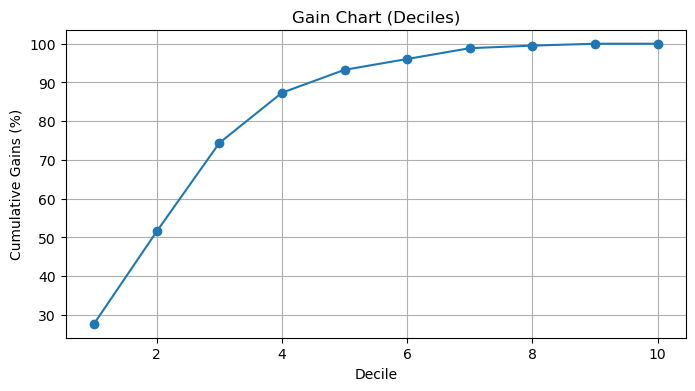

In [283]:
num_deciles = 10
decile_size = len(df) // num_deciles
deciles = [i * decile_size for i in range(num_deciles)] + [len(df)]

# Calculate cumulative gains for each decile
cumulative_gains = []

total_positives = df['actual'].sum()
total_negatives = len(df) - total_positives

for i in range(1, len(deciles)):
    decile_data = df.iloc[deciles[i-1]:deciles[i]]
    cumulative_positives = decile_data['actual'].sum()
    cumulative_gains.append((cumulative_positives / total_positives) * 100)
cumulative_sum = np.cumsum(cumulative_gains)

#print(cumulative_sum)

# Plot the gain chart for deciles
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_deciles + 1), cumulative_sum, marker='o')
plt.xlabel('Decile')
plt.ylabel('Cumulative Gains (%)')
plt.title('Gain Chart (Deciles)')
plt.grid(True)
plt.show()

In [282]:
cumulative_sum = np.cumsum(cumulative_gains)

print(cumulative_sum)

[0.27750411 0.51559934 0.74384236 0.87356322 0.93267652 0.96059113
 0.98850575 0.99507389 1.         1.        ]


### AUG-SEP

In [967]:
discount_24 = pd.read_excel('data/FY24-Discount.xlsx')
discount_groupby = discount_24.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby = discount_groupby.fillna(0)
discount_groupby.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby.index = discount_groupby['sold_to_party_code']
result_sep = result_matrix[result_matrix['2023-08']=='Active']
#result_jun = result_matrix[result_matrix['2023-06']=='Active_1N']
pivot_sep = pivot[pivot.index.isin(result_sep.index)]
#pivot_ = pivot[pivot.index.isin(result_sep.index)]
pivot_sep = pivot_sep[['2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07','2023-08']]
# pivot_jun = pivot_jun[['2021-06','2021-07','2021-08', '2021-09',
#        '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
#        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
result_sep_1 = result_sep[['2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07','2023-08']]
# result_jun_1 = result_jun[['2022-06','2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
pivot_sep.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
# pivot_jun.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
#                                     'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
result_sep_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
# result_jun_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
val_df = instance_2.data(pivot_sep, result_sep_1)
val_df = instance_2.discount_pd(val_df , discount_groupby[['avg_discount']], discount_groupby[['avg_pd']])
val_df = instance_2.district(val_df , distt_df , region_df)

In [972]:
val_df = val_df.merge(pivot_2['actual'], left_index = True , right_index = True , how = 'inner')

In [958]:
#discount_24 = pd.read_excel('data/FY24-Discount.xlsx')
discount_24_1 = discount_24[discount_24['Month']!= "08'23"]
discount_groupby_aug = discount_24_1.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby_aug = discount_groupby_aug.fillna(0)
discount_groupby_aug.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby_aug.index = discount_groupby_aug['sold_to_party_code']

In [959]:
result_aug = result_matrix[result_matrix['2023-08']=='Active_1N']
#result_jun = result_matrix[result_matrix['2023-06']=='Active_1N']
pivot_aug = pivot[pivot.index.isin(result_aug.index)]
#pivot_ = pivot[pivot.index.isin(result_sep.index)]
pivot_aug = pivot_aug[['2021-08','2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
# pivot_jun = pivot_jun[['2021-06','2021-07','2021-08', '2021-09',
#        '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
#        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
result_aug_1 = result_aug[['2022-08','2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
# result_jun_1 = result_jun[['2022-06','2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
pivot_aug.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
# pivot_jun.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
#                                     'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
result_aug_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
# result_jun_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
val_df_aug= instance_2.data(pivot_aug, result_aug_1)
val_df_aug = instance_2.discount_pd(val_df_aug , discount_groupby_aug[['avg_discount']], discount_groupby_aug[['avg_pd']])
val_df_aug = instance_2.district(val_df_aug , distt_df , region_df)

In [974]:
val_df_aug['actual'] = 1

In [983]:
aug_sep = pd.concat([val_df, val_df_aug], axis = 0)

In [987]:
aug_sep = aug_sep.dropna()

In [988]:
X_aug_sep = aug_sep.drop('actual', axis = 1)


In [989]:
import joblib

# Load the model
loaded_model = joblib.load('Random Forest_model.pkl')
X_aug_sep_1 = sc.fit_transform(X_aug_sep)

# Make predictions using the loaded model
predictions = loaded_model.predict(X_aug_sep_1)
proba = loaded_model.predict_proba(X_aug_sep_1)[:,1]

In [991]:
aug_sep['predicted'] = predictions
aug_sep['pred_proba'] = proba

In [995]:
df_2 = aug_sep[['actual','predicted','pred_proba']]
df_2 = df_2.sort_values(by='pred_proba', ascending=False)

In [997]:
def percentile_rank_fun(data, value):
    sorted_data = sorted(data)
    count_below = sum(1 for x in sorted_data if x < value)
    percentile_rank = (count_below / len(sorted_data)) * 100
    return percentile_rank
percentile_rank = []
for i in df_2['pred_proba']:
    rank = percentile_rank_fun(df_2['pred_proba'], i)
    percentile_rank.append(rank)
df_2['percentile_rank'] = percentile_rank

In [998]:
df_2['decile'] = pd.qcut(df_2['percentile_rank'], q=10, labels=False, duplicates='drop')

In [999]:
df_2.columns = df.columns

In [1000]:
# Calculate cumulative gains and cumulative lift for each decile
cumulative_gains = []
cumulative_lift = []

total_positives = df['actual'].sum()
pos_act = []
pos_pred = []
for i in range(9,-1,-1):
    decile_data = df_2[df_2['decile']==i]
    cumulative_positives = decile_data['actual'].sum()
    predicted_positives = decile_data['predicted'].sum()
    print(cumulative_positives)
    pos_act.append(cumulative_positives)
    pos_pred.append( predicted_positives)
    cumulative_gains.append(cumulative_positives / total_positives)
    cumulative_lift.append(cumulative_gains[-1] / (decile_data.shape[0] / total_positives))

245.0
258.0
197.0
118.0
81.0
43.0
21.0
13.0
0.0
2.0


In [1001]:
df_2[df_2['actual']==1].shape[0]/df_2.shape[0]

0.13250237095244546

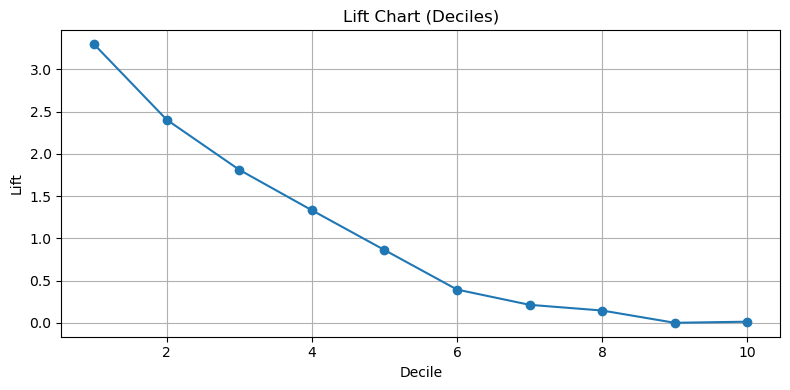

<Figure size 640x480 with 0 Axes>

In [1002]:
for i in range(len(cumulative_lift)):
    cumulative_lift[i] = cumulative_lift[i]/(df_2[df_2['actual']==1].shape[0]/df_2.shape[0])
    
plt.figure(figsize=(8, 4))
plt.plot(range(1,  11), cumulative_lift, marker='o')
plt.xlabel('Decile')
plt.ylabel('Lift')
plt.title('Lift Chart (Deciles)')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('lift.png')

In [1004]:
cumulative_lift

[3.296732870445126,
 2.404114950240411,
 1.8111944689614592,
 1.332249469358262,
 0.8618488253319715,
 0.3934270238618064,
 0.21268838113757899,
 0.1452578886207205,
 0.0,
 0.01303916966567569]

In [1003]:
print('CONFUSION MATRIX AUGUST-SEPTEMBER')
print(confusion_matrix(aug_sep['actual'],aug_sep['predicted']))
print('\n')
print('CLASSIFICATION REPORT AUGUST-SEPTEMBER')
print(classification_report(aug_sep['actual'],aug_sep['predicted']))

CONFUSION MATRIX AUGUST-SEPTEMBER
[[4903 1500]
 [ 278  700]]


CLASSIFICATION REPORT AUGUST-SEPTEMBER
              precision    recall  f1-score   support

         0.0       0.95      0.77      0.85      6403
         1.0       0.32      0.72      0.44       978

    accuracy                           0.76      7381
   macro avg       0.63      0.74      0.64      7381
weighted avg       0.86      0.76      0.79      7381



In [1047]:
for i in range(9,-1,-1):
    decile_data = df_2[df_2['decile']==i]
    print(confusion_matrix(decile_data['actual'],decile_data['predicted']))
    print(classification_report(decile_data['actual'],decile_data['predicted']))

[[  0 318]
 [  0 245]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       318
         1.0       0.44      1.00      0.61       245

    accuracy                           0.44       563
   macro avg       0.22      0.50      0.30       563
weighted avg       0.19      0.44      0.26       563

[[  0 555]
 [  0 258]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       555
         1.0       0.32      1.00      0.48       258

    accuracy                           0.32       813
   macro avg       0.16      0.50      0.24       813
weighted avg       0.10      0.32      0.15       813

[[  0 627]
 [  0 197]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       627
         1.0       0.24      1.00      0.39       197

    accuracy                           0.24       824
   macro avg       0.12      0.50      0.19       824
weigh

In [202]:
val_df.to_excel('sep_val.xlsx')

### October Prediction

In [153]:
discount_24 = pd.read_excel('data/FY24-Discount.xlsx')
discount_groupby = discount_24.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby = discount_groupby.fillna(0)
discount_groupby.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby.index = discount_groupby['sold_to_party_code']
result_oct = result_matrix[result_matrix['actual']=='Active']
#result_jun = result_matrix[result_matrix['2023-06']=='Active_1N']
pivot_oct = pivot_2[pivot_2.index.isin(result_oct.index)]
#pivot_ = pivot[pivot.index.isin(result_sep.index)]
pivot_oct = pivot_oct[['2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07','2023-08','2023-09']]
# pivot_jun = pivot_jun[['2021-06','2021-07','2021-08', '2021-09',
#        '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
#        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
result_oct_1 = result_oct[['2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07','2023-08','actual']]
# result_jun_1 = result_jun[['2022-06','2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
pivot_oct.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
# pivot_jun.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
#                                     'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
result_oct_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
# result_jun_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
val_df_oct = instance_2.data(pivot_oct, result_oct_1)
val_df_oct = instance_2.discount_pd(val_df_oct , discount_groupby[['avg_discount']], discount_groupby[['avg_pd']])
val_df_oct = instance_2.district(val_df_oct , distt_df , region_df)

In [178]:
import joblib

# Load the model
loaded_model = joblib.load('Random Forest_model.pkl')
val_df_oct_1 = sc.fit_transform(val_df_oct)

# Make predictions using the loaded model
predictions = loaded_model.predict(val_df_oct_1)
proba = loaded_model.predict_proba(val_df_oct_1)[:,1]

In [179]:
val_df_oct['prediction'] = predictions
val_df_oct['predict_proba'] = proba

In [181]:
val_df_oct.to_excel('October_active_1N.xlsx')

In [182]:
inactive_result = pd.read_csv('predicted_churn_2023_09-01 (1).csv')

In [184]:
inactive_result.index = inactive_result['dealerId']

In [187]:
result_matrix_inactive = result_matrix[result_matrix.index.isin(inactive_result.index)]

In [191]:
pivot_all = instance.pivot_data()

In [195]:
result_matrix_inactive = pivot_all[pivot_all.index.isin(inactive_result.index)]

In [196]:
result_matrix_inactive

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,25.0,0.0,0.0
7000086,62.0,76.0,12.0,77.0,25.0,83.0,82.0,19.0,12.0,136.0,...,102.0,70.0,11.0,100.0,112.0,56.00,27.50,6.0,60.0,0.0
7000338,213.0,128.5,205.0,204.0,169.0,220.5,250.0,185.5,302.5,352.0,...,304.0,421.0,453.0,427.7,607.5,300.00,228.25,115.5,0.0,0.0
7000421,10.0,10.0,20.0,0.0,20.0,20.0,10.0,0.0,0.0,12.0,...,0.0,12.0,12.0,12.0,10.0,24.00,0.00,25.0,0.0,0.0
7000463,26.0,27.0,0.0,27.0,0.0,0.0,31.0,0.0,30.0,0.0,...,20.0,25.0,30.0,25.0,0.0,31.25,25.00,25.0,31.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,14.0,0.0
7041406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,12.0,0.0
7041429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,14.0,0.0


In [203]:
result_matrix

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,20.0,122.5,75.0,90.0,155.0,46.0,111.0,96.0,80.0,80.00
7000010,57.0,37.0,0.0,24.0,30.0,0.0,41.0,24.0,25.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,24.0,12.0,24.0,13.00
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
7000019,12.0,50.0,133.0,104.0,165.0,123.5,0.0,7.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,21.0,24.0,0.0,29.0,0.0,27.0,12.0,12.0,24.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.00
7041810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.65
7041815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.00


0.475

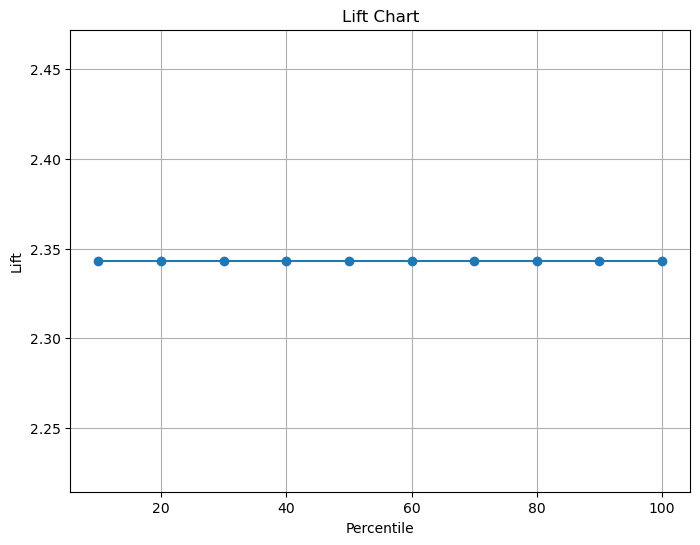

In [211]:
num_percentiles = 10
percentile_values = np.arange(10, 110, 10)
lift_values = []

for percentile in percentile_values:
    threshold = np.percentile(val_df['pred_proba'], 100 - percentile)
    predicted_labels = (val_df['pred_proba']>= threshold).astype(int)
    lift = np.sum(val_df['predicted']) / np.sum(val_df['actual'])
    lift_values.append(lift)

# Plot the lift chart
plt.figure(figsize=(8, 6))
plt.plot(percentile_values, lift_values, marker='o', linestyle='-')
plt.xlabel('Percentile')
plt.ylabel('Lift')
plt.title('Lift Chart')
plt.grid(True)
plt.show()







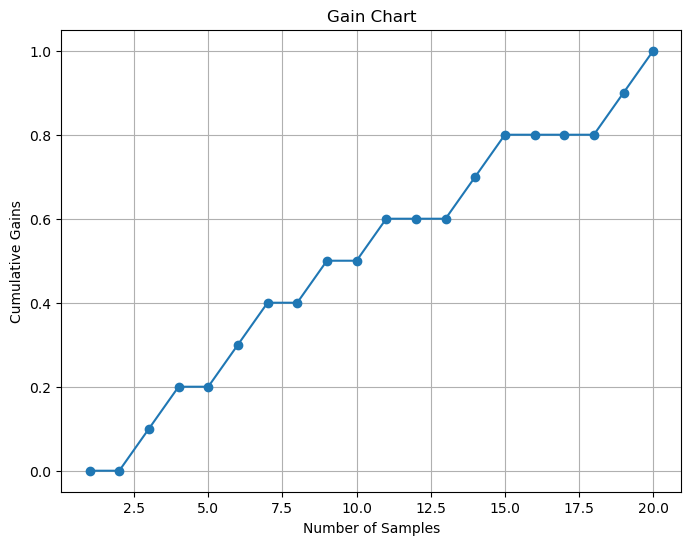

In [212]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Create a random dataset for illustration
np.random.seed(0)
X, y = np.random.rand(100, 5), np.random.choice([0, 1], size=100)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train a classifier (e.g., a RandomForestClassifier)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make predictions and obtain predicted probabilities
y_prob = clf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Calculate cumulative gains
sorted_indices = np.argsort(y_prob)[::-1]
y_sorted = y_test[sorted_indices]
cumulative_gains = np.cumsum(y_sorted) / np.sum(y_test)

# Plot the gain chart
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cumulative_gains) + 1), cumulative_gains, marker='o', linestyle='-')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative Gains')
plt.title('Gain Chart')
plt.grid(True)
plt.show()


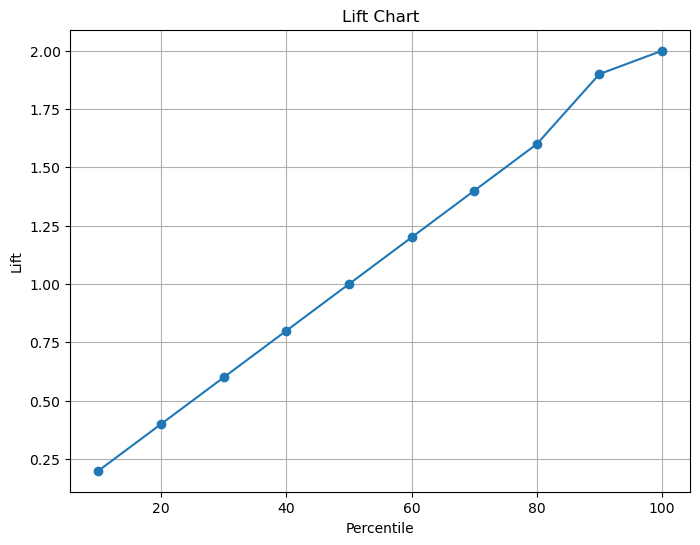

In [209]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Create a random dataset for illustration
np.random.seed(0)
X, y = np.random.rand(100, 5), np.random.choice([0, 1], size=100)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train a classifier (e.g., a RandomForestClassifier)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make predictions and obtain predicted probabilities
y_prob = clf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Calculate the lift values at various percentiles
num_percentiles = 10
percentile_values = np.arange(10, 110, 10)
lift_values = []

for percentile in percentile_values:
    threshold = np.percentile(y_prob, 100 - percentile)
    predicted_labels = (y_prob >= threshold).astype(int)
    lift = np.sum(predicted_labels) / np.sum(y_test)
    lift_values.append(lift)

# Plot the lift chart
plt.figure(figsize=(8, 6))
plt.plot(percentile_values, lift_values, marker='o', linestyle='-')
plt.xlabel('Percentile')
plt.ylabel('Lift')
plt.title('Lift Chart')
plt.grid(True)
plt.show()


### JUL-AUG

In [917]:
jul_aug = pd.read_csv('val_aug_jul.csv')

In [919]:
jul_aug.index = jul_aug['Unnamed: 0']
jul_aug.drop('Unnamed: 0', axis = 1 , inplace = True)

In [921]:
X_jul_aug = jul_aug.drop('m', axis = 1)

In [1005]:
import joblib

# Load the model
loaded_model = joblib.load('Random Forest_model.pkl')
X_jul_aug_1 = sc.fit_transform(X_jul_aug)

# Make predictions using the loaded model
predictions = loaded_model.predict(X_jul_aug_1)
proba = loaded_model.predict_proba(X_jul_aug_1)[:,1]

In [1006]:
jul_aug['predicted'] = predictions
jul_aug['pred_proba'] = proba

In [1007]:
jul_aug['m'] =jul_aug['m'].replace({'Active':0,'Active_1N':1})

In [1008]:
print('CONFUSION MATRIX JULY-AUGUST')
print(confusion_matrix(jul_aug['m'],jul_aug['predicted']))
print('\n')
print('CLASSIFICATION REPORT JULY-AUGUST')
print(classification_report(jul_aug['m'],jul_aug['predicted']))

CONFUSION MATRIX JULY-AUGUST
[[5166 1481]
 [ 250  600]]


CLASSIFICATION REPORT JULY-AUGUST
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      6647
           1       0.29      0.71      0.41       850

    accuracy                           0.77      7497
   macro avg       0.62      0.74      0.63      7497
weighted avg       0.88      0.77      0.81      7497



In [1009]:
df_1 =  jul_aug[['m','predicted','pred_proba']]
df_1 = df_1.sort_values(by='pred_proba', ascending=False)

In [1010]:
def percentile_rank_fun(data, value):
    sorted_data = sorted(data)
    count_below = sum(1 for x in sorted_data if x < value)
    percentile_rank = (count_below / len(sorted_data)) * 100
    return percentile_rank
percentile_rank = []
for i in df_1['pred_proba']:
    rank = percentile_rank_fun(df_1['pred_proba'], i)
    percentile_rank.append(rank)
df_1['percentile_rank'] = percentile_rank


In [1011]:
df_1['decile'] = pd.qcut(df_1['percentile_rank'], q=10, labels=False, duplicates='drop')

In [1012]:
df_1.columns = df.columns

In [1013]:
# Calculate cumulative gains and cumulative lift for each decile
cumulative_gains = []
cumulative_lift = []

total_positives = df['actual'].sum()
pos_act = []
pos_pred = []
for i in range(9,-1,-1):
    decile_data = df_1[df_1['decile']==i]
    cumulative_positives = decile_data['actual'].sum()
    predicted_positives = decile_data['predicted'].sum()
    print(cumulative_positives)
    pos_act.append(cumulative_positives)
    pos_pred.append( predicted_positives)
    cumulative_gains.append(cumulative_positives / total_positives)
    cumulative_lift.append(cumulative_gains[-1] / (decile_data.shape[0] / total_positives))

227
247
126
111
67
40
15
8
6
3


In [1014]:
df_1[df_1['actual']==1].shape[0]/df_1.shape[0]

0.11337868480725624

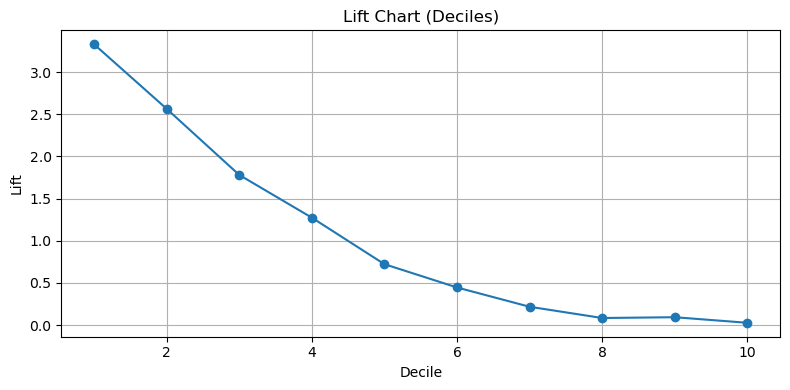

<Figure size 640x480 with 0 Axes>

In [1015]:
for i in range(len(cumulative_lift)):
    cumulative_lift[i] = cumulative_lift[i]/(df_1[df_1['actual']==1].shape[0]/df_1.shape[0])
    
plt.figure(figsize=(8, 4))
plt.plot(range(1,  11), cumulative_lift, marker='o')
plt.xlabel('Decile')
plt.ylabel('Lift')
plt.title('Lift Chart (Deciles)')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('lift.png')

In [1016]:
print('CONFUSION MATRIX JULY-AUGUST')
print(confusion_matrix(jul_aug['m'],jul_aug['predicted']))
print('\n')
print('CLASSIFICATION REPORT JULY-AUGUST')
print(classification_report(jul_aug['m'],jul_aug['predicted']))

CONFUSION MATRIX JULY-AUGUST
[[5166 1481]
 [ 250  600]]


CLASSIFICATION REPORT JULY-AUGUST
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      6647
           1       0.29      0.71      0.41       850

    accuracy                           0.77      7497
   macro avg       0.62      0.74      0.63      7497
weighted avg       0.88      0.77      0.81      7497



In [1041]:
decile_3 = df_1[df_1['decile'].isin([9,8,7])]
decile_3.shape

(2081, 5)

In [1042]:
decile_3[decile_3['actual']==1].shape[0]/850

0.7058823529411765

In [1043]:
decile_4 = df_1[df_1['decile'].isin([9,8,7,6])]
decile_4.shape

(2852, 5)

In [1044]:
decile_4[decile_4['actual']==1].shape[0]/850

0.8364705882352941

In [1045]:
for i in range(9,-1,-1):
    decile_data = df_1[df_1['decile']==i]
    print(confusion_matrix(decile_data['actual'],decile_data['predicted']))
    print(classification_report(decile_data['actual'],decile_data['predicted']))

[[  0 376]
 [  0 227]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       376
           1       0.38      1.00      0.55       227

    accuracy                           0.38       603
   macro avg       0.19      0.50      0.27       603
weighted avg       0.14      0.38      0.21       603

[[  0 605]
 [  0 247]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       605
           1       0.29      1.00      0.45       247

    accuracy                           0.29       852
   macro avg       0.14      0.50      0.22       852
weighted avg       0.08      0.29      0.13       852

[[  0 500]
 [  0 126]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       500
           1       0.20      1.00      0.34       126

    accuracy                           0.20       626
   macro avg       0.10      0.50      0.17       626
weigh

In [ ]:
df_1

In [1046]:
227+247+126

600

In [1017]:
cumulative_lift

[3.3314254685275686,
 2.5655407370476544,
 1.781220843111199,
 1.274060810578148,
 0.7221928793937892,
 0.44582153763848326,
 0.21690091965989935,
 0.0833880567455726,
 0.09282752645584504,
 0.026628558241094964]

In [949]:
df_1['actual'].value_counts()

0    6647
1     850
Name: actual, dtype: int64

In [950]:
jul_aug['m'].value_counts()

0    6647
1     850
Name: m, dtype: int64

In [951]:
850/(850+6647)

0.11337868480725624

In [1023]:
result_matrix_1 = result_matrix.merge(pivot_2['actual'], left_index = True , right_index = True , how = 'inner')

In [1028]:
condition =  ((result_matrix_1['2023-08']=='Active') & (result_matrix_1['actual']==0.0))
result_matrix_1.loc[condition, 'actual'] = 'Active'
condition =  ((result_matrix_1['2023-08']=='Active_1N') & (result_matrix_1['actual']==0.0))
result_matrix_1.loc[condition, 'actual'] = 'Active' 
condition =  ((result_matrix_1['2023-08']=='Active_2N') & (result_matrix_1['actual']==0.0))
result_matrix_1.loc[condition, 'actual'] = 'Active' 
condition =  ((result_matrix_1['2023-08']=='Active_3N') & (result_matrix_1['actual']==0.0))
result_matrix_1.loc[condition, 'actual'] = 'Active'
condition =  ((result_matrix_1['2023-08']=='Inactive') & (result_matrix_1['actual']==0.0))
result_matrix_1.loc[condition, 'actual'] = 'Active'
condition =  ((result_matrix_1['2023-08']=='Churn') & (result_matrix_1['actual']==0.0))
result_matrix_1.loc[condition, 'actual'] = 'Active'
condition =  ((result_matrix_1['2023-08']=='Active_1N') & (result_matrix_1['actual']==1.0))
result_matrix_1.loc[condition, 'actual'] = 'Active_2N'
condition =  ((result_matrix_1['2023-08']=='Active_2N') & (result_matrix_1['actual']==1.0))
result_matrix_1.loc[condition, 'actual'] = 'Active_3N'
condition =  ((result_matrix_1['2023-08']=='Active_3N') &(result_matrix_1['actual']==1.0))
result_matrix_1.loc[condition, 'actual'] = 'Inactive'
condition =  ((result_matrix_1['2023-08']=='Inactive') & (result_matrix_1['actual']==1.0))
result_matrix_1.loc[condition, 'actual'] = 'Churn'

In [1030]:
condition =  ((result_matrix_1['2023-08']=='Churn') & (result_matrix_1['actual']==1.0))
result_matrix_1.loc[condition, 'actual'] = 'Churn'
condition =  ((result_matrix_1['2023-08']=='Active') & (result_matrix_1['actual']==1.0))
result_matrix_1.loc[condition, 'actual'] = 'Active_1N'

In [1033]:
result_matrix_1[result_matrix_1['2023-07']]

Active       9410
Churn        2578
Inactive     1563
Active_1N     605
Active_2N     295
-             283
Active_3N     234
Name: 2023-07, dtype: int64